### Order of Steps

Non-Tokenized-Based
- Perform VADER on unprocessed data (case and punctuation sensitive)
- Perform Lowercasing 
- Perform Readability (stopwords, punctuation matters)
- Count Exclamation (efore removing punctuation)
- Remove Punctuation

Tokenized-Based
- Tokenize
- Calculate Lexical Diversity (before removing stopwords)
- Count Superlatives using PoS Tagging
- Stemming 

### 1. Import

In [128]:
# Base Imports
import pandas as pd
import matplotlib.pyplot as plt

# NLTK Imports
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag

# Others

# Readability
import textstat
# Boxplot
import seaborn as sns
# Display stuff nice
import textwrap

In [149]:
# Read the first 5,000 rows from each file
df1 = pd.read_csv('archive_kaggle_data/Constraint_Train.csv')
df2 = pd.read_csv('archive_kaggle_data/Constraint_Val.csv')
df3 = pd.read_csv('archive_kaggle_data/Constraint_Test.csv')

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)


In [153]:
# Only keep fake news
combined_df = combined_df[combined_df["label"] == "fake"]
combined_df

In [151]:
# Add labels to the dataframes
# Let's assume that -1 indicates true news and +1 indicates fake news
true_df['label'] = -1
fake_df['label'] = 1

### Observe Data

In [130]:
combined_df

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",-1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",-1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",-1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",-1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",-1
...,...,...,...,...,...
9995,FBI Warns Republicans: Do Not Leak Clinton Em...,It s no secret Republicans are salivating to f...,News,"August 18, 2016",1
9996,Justice Department Announces It Will No Longe...,Republicans are about to lose a huge source of...,News,"August 18, 2016",1
9997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,A pawn working for Donald Trump claimed that w...,News,"August 18, 2016",1
9998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,Fox News is desperate to sabotage Hillary Clin...,News,"August 18, 2016",1


In [131]:
# sample
combined_df = combined_df.sample(frac=1, random_state=42)

# Assume that `articles` is a pandas Series with the text of each article
for i, article in enumerate(combined_df["text"]):
    print(f'Article {i+1}:')
    print("Label: ", combined_df["label"].iloc[i], "\n")
    print(combined_df["title"].iloc[i], "\n")
    print(textwrap.fill(article, width=80))
    print('\n' + '-' * 80 + '\n')  # Print a separator
    if i > 11:
        break


Article 1:
Label:  1 

 Trump Steals $100K from Children’s Cancer Charity To Line His Own Pockets 

In another despicable headline focused on the actions of President Trump, Forbes
reported on Tuesday that Trump has funneled over $100,000 in St. Jude Children s
Hospital donations into Trump Organization revenue.Trump s son Eric hosts an
annual golf tournament to raise millions for the St. Jude children s Research
Hospital. The Eric Trump Foundation reportedly funneled $100,000 of the
donations right back to Trump s golf courses   to take care of  incurred
expenses    instead of going to the charity where the donors had been promised
they would go.To top this off, over the past 10 years $500,000 of donated money
was conveniently  re-donated  to different charities, including ones connected
to family members of Trump. Most of these organizations were using the Trump
golf courses for the fund raising tournaments, meaning Trump could have been
making additional hundreds-of-thousands off of

### Preprocessing and Feature Extraction

In [132]:
# Create feature DF
feature_df = pd.DataFrame()
feature_df['label'] = combined_df['label']

#### Vader Sentiment

In [133]:
# VADER Sentiment (used on unprocessed text, as punctuation and cases are considered)

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()


# Function to calculate sentiment score using VADER
def calculate_sentiment_vader(text):
    return (sid.polarity_scores(text)["compound"])


# Apply the function to each row in the DataFrame
feature_df['sentiment_vader'] = combined_df['text'].apply(
    calculate_sentiment_vader)

# Display the DataFrame with the new 'sentiment_vader' column
print(feature_df)


      label  sentiment_vader
6252      1           0.3217
4684     -1           0.9981
1731     -1           0.9758
4742     -1           0.2732
4521     -1           0.9931
...     ...              ...
5734      1          -0.9838
5191      1          -0.9927
5390      1           0.8397
860      -1           0.8775
7270      1          -0.9951

[10000 rows x 2 columns]


#### Lowercase

In [134]:
# Lowercase
combined_df['preprocessed'] = combined_df['text'].str.lower()

#### Readability

In [135]:
# Kincaid Readabilility score
# Note that for calculating the Flesch-Kincaid readability score, steps like tokenization,
# lemmatization/stemming, and stop word removal are not necessary because the formula for the
# score relies on the original sentence structure, word count, and syllable count.
# The basic cleaning like lowercasing, and removing HTML tags, noise, punctuation, and special characters would suffice.

# Apply the Flesch-Kincaid grade level test to each row in the DataFrame
feature_df['readability'] = combined_df['preprocessed'].apply(
    textstat.flesch_kincaid_grade)

# Display the DataFrame with the new 'readability' column
print(feature_df)


      label  sentiment_vader  readability
6252      1           0.3217         12.3
4684     -1           0.9981         10.3
1731     -1           0.9758         12.1
4742     -1           0.2732         35.7
4521     -1           0.9931         11.9
...     ...              ...          ...
5734      1          -0.9838         10.2
5191      1          -0.9927          7.9
5390      1           0.8397          7.6
860      -1           0.8775         13.0
7270      1          -0.9951         10.8

[10000 rows x 3 columns]


#### Count Exclamation

In [136]:
# Punctuation
# Propbably more than one exclamation mark is rare, not very serious at all (not even in fake news)

def count_exclamation_marks(text):
    return text.count('!')

# Apply the function to each row in the DataFrame
feature_df['exclamation_marks'] = combined_df['preprocessed'].apply(
    count_exclamation_marks)

# Display the DataFrame with the new 'exclamation_marks' column
print(feature_df)


      label  sentiment_vader  readability  exclamation_marks
6252      1           0.3217         12.3                  0
4684     -1           0.9981         10.3                  0
1731     -1           0.9758         12.1                  0
4742     -1           0.2732         35.7                  0
4521     -1           0.9931         11.9                  0
...     ...              ...          ...                ...
5734      1          -0.9838         10.2                  0
5191      1          -0.9927          7.9                  2
5390      1           0.8397          7.6                  2
860      -1           0.8775         13.0                  0
7270      1          -0.9951         10.8                  2

[10000 rows x 4 columns]


#### Tokenize 

In [137]:
# Tokenize
combined_df['preprocessed'] = combined_df['preprocessed'].apply(
    nltk.word_tokenize)

#### Remove Punctuation

In [138]:
# Remove Punctuation
combined_df['preprocessed'] = combined_df['preprocessed'].apply(
    lambda x: [word for word in x if word.isalnum()])

#### Lexical Diversity

In [139]:
# Lexical Diversity

def lexical_diversity(words):

    # Compute the number of unique words (types)
    types = set(words)

    # Compute the total number of words (tokens)
    tokens = len(words)

    # Compute the type-token ratio (TTR)
    ttr = len(types) / tokens if tokens > 0 else 0

    return ttr

# Apply the function to each text in your DataFrame
feature_df['lexical_diversity'] = combined_df['preprocessed'].apply(lexical_diversity)


#### Remove Stop Words

In [140]:
# Remove stop words
stop_words = set(stopwords.words('english'))

combined_df['preprocessed'] = combined_df['preprocessed'].apply(
    lambda x: [word for word in x if word not in stop_words])


#### Count Superlatives

In [141]:
# PoS Tagging

def count_superlatives(words):

    # Tag parts of speech
    tagged_words = pos_tag(words)

    # Count superlatives
    superlatives = sum(1 for word, pos in tagged_words
                       if pos in {'JJS', 'RBS'})

    return superlatives


# Apply the function to each text in your DataFrame
feature_df['superlatives'] = combined_df['preprocessed'].apply(
    count_superlatives)


#### Stemming

In [142]:
# Stemming
stemmer = nltk.PorterStemmer()

combined_df['preprocessed'] = combined_df['preprocessed'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x]))


In [143]:
print(combined_df)

                                                  title  \
6252   Trump Steals $100K from Children’s Cancer Cha...   
4684  Instant View: Republicans pull Obamacare repea...   
1731  U.S. judge presses Trump administration on Dre...   
4742        House delays vote on healthcare bill: MSNBC   
4521  Trump presses China on North Korea ahead of Xi...   
...                                                 ...   
5734   Trump Will ‘Torture’ Sessions Every Day Until...   
5191   Trump Wets His Pants Over Bob Corker Again, C...   
5390   Trump Shamefully Uses Hurricane Devastation T...   
860   Republican tax plan would deal financial hit t...   
7270   WATCH: Even Investigation-Obsessed GOP Rep. J...   

                                                   text       subject  \
6252  In another despicable headline focused on the ...          News   
4684  (Reuters) - Republican leaders of the House of...  politicsNews   
1731  NEW YORK (Reuters) - A U.S. judge on Thursday ...  politicsNews   

In [144]:
print(feature_df)

      label  sentiment_vader  readability  exclamation_marks  \
6252      1           0.3217         12.3                  0   
4684     -1           0.9981         10.3                  0   
1731     -1           0.9758         12.1                  0   
4742     -1           0.2732         35.7                  0   
4521     -1           0.9931         11.9                  0   
...     ...              ...          ...                ...   
5734      1          -0.9838         10.2                  0   
5191      1          -0.9927          7.9                  2   
5390      1           0.8397          7.6                  2   
860      -1           0.8775         13.0                  0   
7270      1          -0.9951         10.8                  2   

      lexical_diversity  superlatives  
6252           0.591760             0  
4684           0.411765             1  
1731           0.591584             0  
4742           0.790123             0  
4521           0.450402        

In [145]:
# ...

### Feature Selection

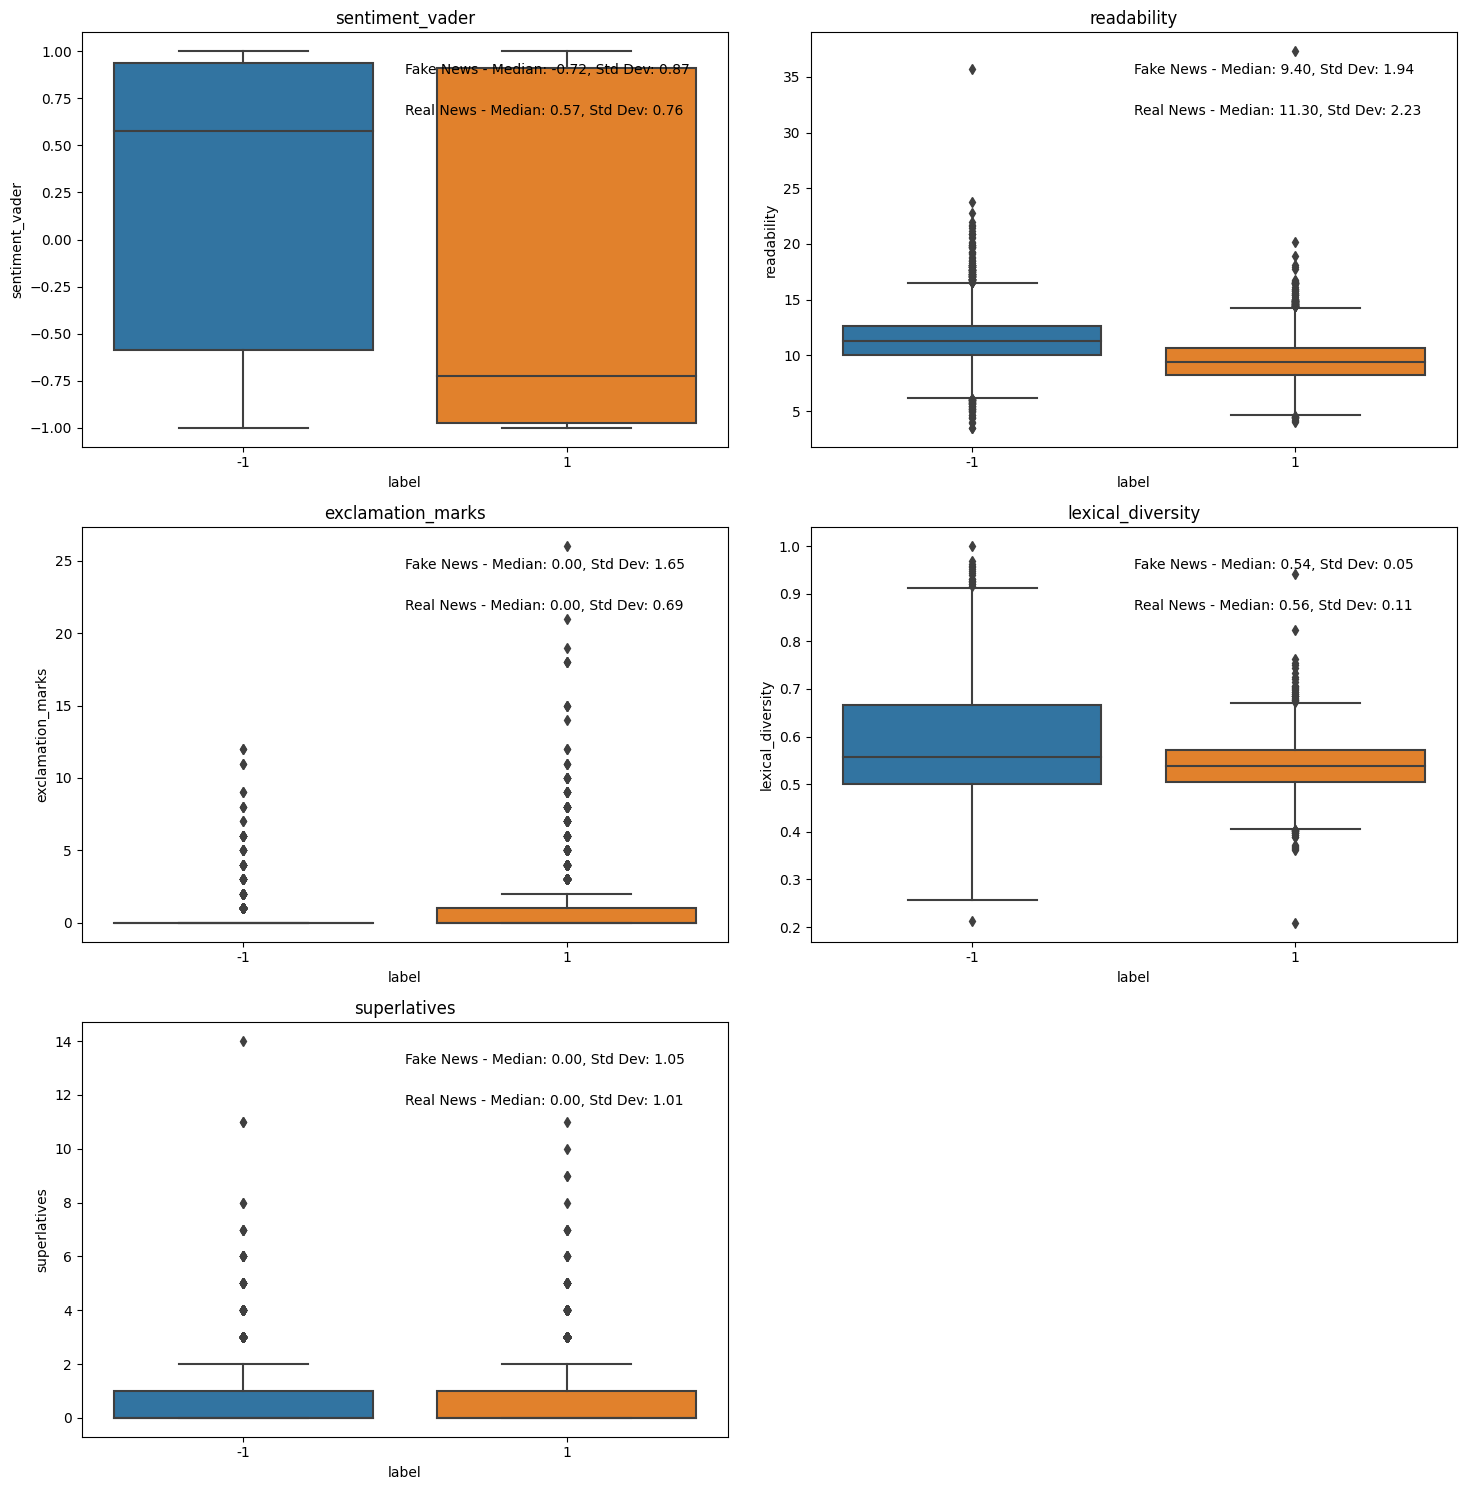

In [146]:

features = feature_df.columns.drop('label')

# Define the number of rows and columns for the subplot grid
n = len(features)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()  # Flatten to make indexing easier

for i, feature in enumerate(features):
    # Calculate median and standard deviation for the feature by class
    median_fake = feature_df[feature_df['label'] == 1][feature].median()
    std_dev_fake = feature_df[feature_df['label'] == 1][feature].std()

    median_real = feature_df[feature_df['label'] == -1][feature].median()
    std_dev_real = feature_df[feature_df['label'] == -1][feature].std()

    # Create the boxplot
    sns.boxplot(x='label', y=feature, data=feature_df, ax=axs[i])

    # Set the title with median and standard deviation
    axs[i].set_title(f'{feature}')

    # Add the calculated stats in the plot
    axs[i].text(0.5, 0.9, f'Fake News - Median: {median_fake:.2f}, Std Dev: {std_dev_fake:.2f}',
                transform=axs[i].transAxes)
    axs[i].text(0.5, 0.8, f'Real News - Median: {median_real:.2f}, Std Dev: {std_dev_real:.2f}',
                transform=axs[i].transAxes)

# Remove extra subplots
if len(features) < len(axs):
    for i in range(len(features), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


### Baseline Classififer

In [147]:
# shuffle the feature_df
feature_df = feature_df.sample(frac=1, random_state=42)

In [148]:
### Linear SVM

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Separate features and labels
X = feature_df.drop('label', axis=1)
y = feature_df['label']

# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create and fit the model
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = model.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of the Linear SVM model is: {accuracy*100:.2f}%')


The accuracy of the Linear SVM model is: 72.80%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
